# 2. Fitting a model - Solutions

After defining a model, they next step would be to fit this model. Model fitting is a measure of how well the model can predict the values of the actual data. The goal of model fitting is to define the parameters that best define the actual data. In this tuturial, we will focus on a subjects' alpha value.

In this tutorial, we will again use functions defined in earlier tutorials. 

## Plan

1. Think about how to define 'model fit', i.e. when is a model good?
2. Computing model fit for a given model
3. Model fitting: finding the parameters of the model that yield the best model fit
3. Fitting the model for different subjects

### Import packages

In [1]:
import os, sys, glob, scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
base_dir = os.path.realpath('.')
print(base_dir)

/Users/daantjedebruin/Documents/GitHub/Computational_modeling_tutorial


### Define functions from before

##### Choice models

In [3]:
def inequity_aversion(params, offer):

    # Inequity aversion model with one inequity term (= symmetric) and a money term
    payoffs = [offer, 0]
    inequities = [(100-offer)-offer, 0]
    utilities = payoffs - np.multiply(params[0],inequities)
    choice = np.where(utilities == np.max(utilities))[0][0]

    return choice

In [4]:
def random_model(params, offer):
    
    choice = np.random.randint(0,2)
    
    return choice

##### Simulation code

In [5]:
def simulate_model(model, data_to_simulate, params = None):
    
    # Input variables: 
    # - model: the model that you are using
    # - data_to_simulate: the actual subject data
    # - params: the parameters (alpha, beta) that will be used for simulating the model. Default is None. 
    
    # Create output dataframe
    simulation_results = data_to_simulate.copy()
    
    # Loop over trials and simulate each trial
    for trial in data_to_simulate['trial']:
        offer = data_to_simulate.loc[data_to_simulate['trial']==trial, 'offer'].values[0]
        predicted_choice = model(params, offer)
        # store in output dataframe:
        simulation_results.loc[data_to_simulate['trial']==trial,'choice'] = predicted_choice
        
    # Output: results of the simulation    
    return simulation_results

In [6]:
def plot_simulation(simulated_sub_data):
    
    fig = sns.scatterplot(data = simulated_sub_data, x = 'offer', y = 'choice')
    
    return fig

### Load some data

In [7]:
data_dir = base_dir + '/Data'
print(data_dir)

/Users/daantjedebruin/Documents/GitHub/Computational_modeling_tutorial/Data


In [8]:
data = pd.read_csv(data_dir + '/Study1_UG.csv')
# Only use the subject nr, trial, unfairness and choice columns 
data = data[['sub','trial','unfairness','choice']]
# Compute a column 'offer', which is 100 - unfairness of the offer. 
data['offer'] = 100 - data['unfairness']
data.head()

,sub,trial,unfairness,choice,offer
0,1,1,50,0,50
1,1,2,80,0,20
2,1,3,95,0,5
3,1,4,60,0,40
4,1,5,75,0,25


## 1.How to define model fit?

There are multiple ways to fit a model. Let's start with a metric of model fit that you might know from regression: the sum of squared error (SSE). 
Before we compute the SSE, let's start by visually inspecting the data. 

In [9]:
# Load data for a subject
sub = 20
# Only select the data for that subject 
sub_data = data.query('sub == %i'%sub)[['trial','offer','choice']]
sub_data.head()

,trial,offer,choice
340,1,30,0
341,2,45,0
342,3,20,1
343,4,40,0
344,5,40,0


##### EXERCISE: Plot the subject's data as well as simulated data from the random model side-by-side

To do this, use the previously defined functions to simulate and plot the simulated data. Other helpful packages might be:
- plt.subplots: this function enables you to plot different subplots side-by-side
- plt.scatter: the best way to visualize this data is by using a scatterplot

[(-0.1, 1.1),
 Text(0, 0.5, 'choice'),
 Text(0.5, 0, 'offer'),
 Text(0.5, 1.0, 'SIMULATION')]

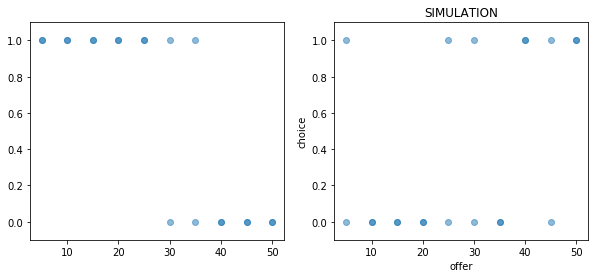

In [10]:
# Make a figure with two axes
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = [10,4])

# Plot data
axes[0].scatter(x = sub_data['offer'], y = sub_data['choice'], alpha = .5)
axes[0].set(ylim = [-.1,1.1])

# Simulating the model
data_to_simulate = sub_data.copy()
simulated_data = simulate_model(random_model, data_to_simulate)

# Plot the model
axes[1].scatter(x = simulated_data['offer'], y = simulated_data['choice'], alpha = .5)
axes[1].set(title = 'SIMULATION', xlabel = 'offer', ylabel = 'choice', ylim = [-.1,1.1])

## 2.Compute model fit for a given model

As has been previously described, the model fit describes how wel a model can predict the values of the actual data. It is thus a measure of similarity between the actual data and the data that was simulated by the model. One way of computing model fit is by using the sum of squared error (SSE). 
The SSE is a measure of variance of the simulated data from the actual data. It is computed by substracting the simulated values from the actual values to find the deviation (or the errors). These errors are then squared. 

Some advantages of using the SSE are:
1. It is absolute: it can integrate positive and negative deviations (as they are squared)
2. It is familiar: the SSE is also used in regression
3. It is simple
4. It allows you to directly compare a point prediction (from your model) and an observation data point (we will work with probability distributions later on).
5. It ensures that outliers have a bigger impact on your error, e.g. 1 outlier can drive up SSE more than 3 near points. Maybe that's a good thing, maybe not?

###### Compute the model fit for the random model using the SSE 

In [11]:
# First merge the two dataframes (actual data, simulated data) to make sure the offers match up:
total_data = sub_data.merge(simulated_data, on = ['trial','offer'], suffixes = ['_subject', '_simulation'])

# Then compute the errors by substracting the simulated values from the actual values
errors = total_data['choice_subject'] - total_data['choice_simulation']

# Then, compute the sum of squared errors:
SSE = np.sum(np.square(errors))
print('Sum of squared error = %i'%SSE)

Sum of squared error = 14


Now we know how 'good' or 'bad' the model is. But are the errors in one specific direction? For example, a model that always predicts 'accept' will be correct about 'accept' trials 100% of time time, but always wrong about 'reject' trials. To find out, we can use the confusion matrix:

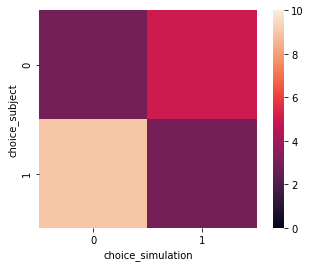

In [12]:
# First, we select the subjects' choice and simulations' choices and count how often they made every decision (1 or 0).
# Then, we create a matrix of the subjects' choice by the simulations' choice, which we call the confusion_matrix. 
confusion_matrix = (total_data[['choice_subject','choice_simulation','trial']]
                    .groupby(['choice_subject','choice_simulation']).count()
                    .reset_index().pivot(index='choice_subject', columns = 'choice_simulation', values = 'trial'))
# We plot the matrix using a heatmap, in which the frequency of overlap between the choices is color coded. 
sns.heatmap(confusion_matrix, square = True, vmin = 0, vmax = 10)

In [13]:
# We can also compute the number of "hits", e.g. the number of cases in which the simulated choices were the same as 
# the actual choices. 
total_data['correct'] = total_data['choice_subject'] == total_data['choice_simulation']
hits = np.sum(total_data['correct'])
print('%i hits'%hits)

6 hits


##### EXERCISE: Compute model fit for inequity aversion model
Similar to the model fitting of the random model, now compute the model fit and the number of hits for the inequity aversion model. Use the earlier specified functions to simulate data. Choose a random alpha value for the model.

In [14]:
# Simulate data, here a alpha of 2 was chosen
simulated_data = simulate_model(inequity_aversion, data_to_simulate, [2])

# First merge the two dataframes (actual data, simulated data) to make sure the offers match up:
total_data = sub_data.merge(simulated_data, on = ['trial','offer'], suffixes = ['_subject', '_simulation'])

# Then compute the errors by substracting the simulated values from the actual values
errors = total_data['choice_subject'] - total_data['choice_simulation']

# Then, compute the sum of squared errors:
SSE = np.sum(np.square(errors))
print('Sum of squared error = %i'%SSE)

# Compute number of hits
total_data['correct'] = total_data['choice_subject'] == total_data['choice_simulation']
hits = np.sum(total_data['correct'])
print('%i hits'%hits)

Sum of squared error = 2
18 hits


In this case, the SSE and the number of hits are perfectly correlated (hits = 20 - SSE), so we can pick just one as our objective function (the measure of model fit). In this tutorial, we will use continue using hits as our measure of model fit.

## 3.Model fitting: finding the parameters of the model that yield the best model fit

As has been described before, the goal of model fitting is to define the parameters that best define the actual data. In the previous exercises, we either used a random model (no parameters) or a randomly chosen alpha value. We will now use model fitting to find the parameters that best fit the subjects behavior. 

Finding these parameters is often done using a grid search. In a grid search, you "loop" through different values of the parameters and compute the fit for every combination of parameters. By doing this, you can thus find a combination of parameters of the model that most accurately describe the actual data. 

In this tutorial, we will only use the alpha value as a parameter in the inequity aversion model. We will thus loop through different alpha values and compute which alpha value best fits the data for this model.

##### Compute the model fit for many different values of alpha

In [15]:
# Create a range of alphas, ranging from 0 to 10 with steps of 0.1
range_of_alphas = np.arange(0,10,.1)

# Create a dataframe to store the results of our model fitting in
model_results = pd.DataFrame(columns=['alpha','hits'])

# Loop through the different alpha values and compute the model fit for that alpha 
for alpha in range_of_alphas:
    
    # Simulate the model
    simulated_data = simulate_model(inequity_aversion, data_to_simulate, [alpha])
    
    # Merge observed and simulated data
    total_data = sub_data.merge(simulated_data, on = ['trial','offer'], suffixes = ['_subject', '_simulation'])
    
    # Compute hits
    total_data['correct'] = total_data['choice_subject'] == total_data['choice_simulation']
    hits = np.sum(total_data['correct'])
    
    # Store results in the dataframe by appending them 
    tmp = pd.DataFrame([[alpha,hits]], columns=model_results.columns)
    model_results = model_results.append(tmp)

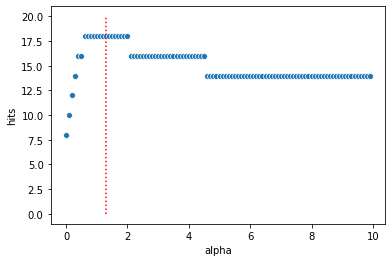

In [16]:
# Plot the results of our different alpha values 
sns.scatterplot(data = model_results, x = 'alpha', y = 'hits')
best_alpha = model_results.query('hits == %i'%np.max(model_results.hits))['alpha'].mean()
plt.plot([best_alpha, best_alpha], [0,20], 'r:')

This plot shows you the number of hits for every alpha. The red line shows the value of alpha where you get the maximum number of hits, i.e. the best 'model fit'!

## 4.Fitting the model for different subjects

Now we can automate the fitting procedure and try it for a group of subjects.

##### EXERCISE: Write a function 'subject_fit' that takes subject data and model as inputs and returns the best alpha
Use and adjust the previously written code. The outline for the function is already provided.

In [17]:
def subject_fit(subject_data, model, min_alpha, max_alpha, alpha_step):
    
    range_of_alphas = np.arange(min_alpha, max_alpha, alpha_step)

    # Create a dataframe to store the results in
    model_results = pd.DataFrame(columns=['alpha','hits'])

    for alpha in range_of_alphas:

        # Simulate the model
        simulated_data = simulate_model(model, subject_data, [alpha])

        # Merge observed and simulated data
        total_data = subject_data.merge(simulated_data,
                            on = ['trial','offer'], suffixes = ['_subject', '_simulation'])

        # Compute hits
        total_data['correct'] = total_data['choice_subject'] == total_data['choice_simulation']
        hits = np.sum(total_data['correct'])

        # Store result
        tmp = pd.DataFrame([[alpha,hits]], columns=model_results.columns)
        model_results = model_results.append(tmp)
    
    # Last step: select the best alpha
    best_hits = np.max(model_results['hits'])
    best_alphas = model_results.query('hits == %i'%best_hits)['alpha'].values
    best_alpha = np.mean(best_alphas)
    
    return best_alpha, best_hits, total_data, model_results

In [18]:
# Test if the function works
# Load data for a subject
sub = 20
sub_data = data.query('sub == %i'%sub)[['trial','offer','choice']]
sub_data.head()

,trial,offer,choice
340,1,30,0
341,2,45,0
342,3,20,1
343,4,40,0
344,5,40,0


In [19]:
# Check the output 
best_alpha, best_hits, total_data, model_results = subject_fit(sub_data, inequity_aversion, 0, 10, .1)
model_results.head()

,alpha,hits
0,0.0,8
0,0.1,10
0,0.2,12
0,0.3,14
0,0.4,16


#### Loop over subjects
Now, we can loop over multiple subjects and compute the best alpha for every subject. To do this, we use a for loop and the previously defined subject_fit() function. 

In [20]:
# Create dataframe to store the results in
model_fits = pd.DataFrame(columns=['subject','best_alpha','hits'])
# As the dataset is very large, we now only loop through the first 20 subjects. 
for sub in np.arange(1,21):
    print(sub, end = ', ')
    # Load data for a subject
    sub_data = data.query('sub == %i'%sub)[['trial','offer','choice']]
    sub_data.head()
    # Fit model
    best_alpha, best_hits, total_data, model_results = (
        subject_fit(sub_data, inequity_aversion, 0, 10, .1))
    # Store
    tmp = pd.DataFrame([[sub, best_alpha, best_hits]], columns=model_fits.columns)
    model_fits = model_fits.append(tmp).reset_index(drop=True)

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 

The best way to inspect the output is by plotting the data. Plot the distribution of 'best_alpha' and 'hits' to see how well our model does for the given best alpha values.

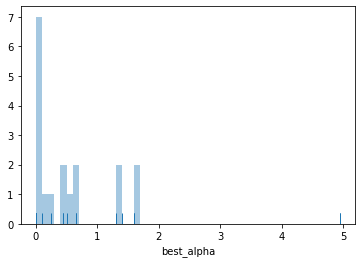

In [21]:
# Plot 1: distribution of alphas
sns.distplot(model_fits['best_alpha'], bins = np.arange(0, 2, .1), rug = True, kde = False)

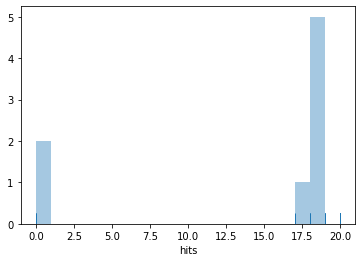

In [22]:
# Plot 2: distribution of number of hits
sns.distplot(model_fits['hits'], bins = np.arange(0, 20), kde = False, rug = True)

We have now fitted to model using the SSE/number of hits for multiple subjects. Similarly, we can fit other models to find the parameters that best describe the observed data. 

## During next session, we will:

- Talk about different model fit metrics
- Talk about different choice rules (Softmax, epsilon-greedy)